### LoopFlopy Example 3 - Adding Heterogeneity  
WORK IN PROGRESS DON'T USE

In [53]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
#for module in modules: print(module)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\users\00105295\projects\loopflopy\loopflopy\__init__.py


### 1. Setup Project

In [54]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)
project.crs = 28350  # UTM zone 50S, EPSG:28350

### 2. Spatial

In [55]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial

process_spatial.make_bbox_shp(spatial, x0 = 348000, x1 = 390000, y0 = 6503000, y1 = 6520000) # x1 = 415000
process_spatial.model_boundary(spatial, boundary_buff = 500, simplify_tolerance = 800, node_spacing = 1000)
#process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
spatial.x0, spatial.x1, spatial.y0, spatial.y1

(363206.86262235837, 390000.0, 6503000.0380154895, 6520000.0)

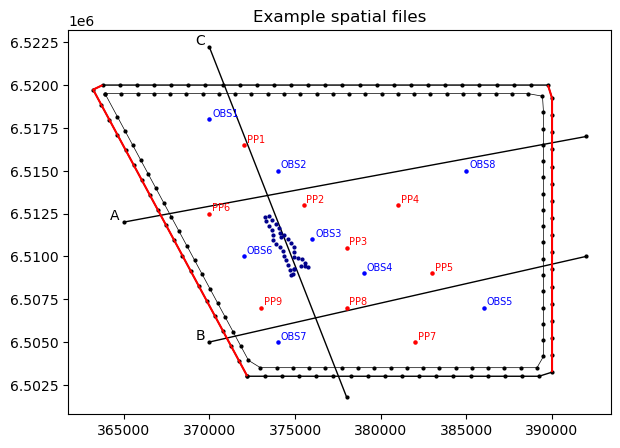

In [56]:
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.pilot_points(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)
process_spatial.lakes(spatial)

spatial.xsection_names = ['A', 'B', 'C']
spatial.xsections = [
                     [(365000, 6512000),(392000, 6517000)], 
                     [(370000, 6505000),(392000, 6510000)],
                     [(370000, 6522200),(378000, 6501800)]
                     ]
process_spatial.plot_spatial(spatial, 
                             obsbores = True, 
                             pilotpoints = True,
                             pumpbores = False, 
                             geobores = False, 
                             xsections = True, 
                             fault = False)

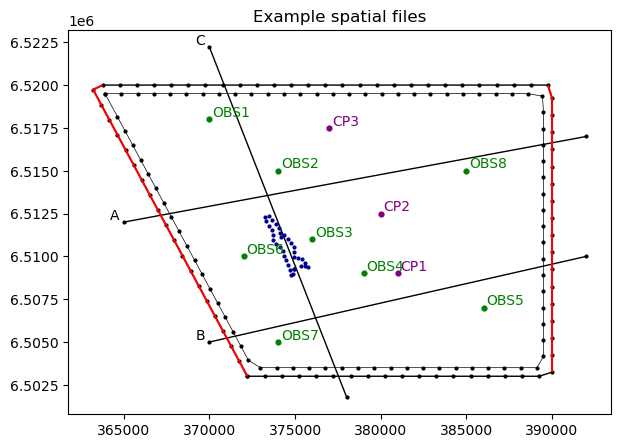

In [57]:
process_spatial.plot_spatial(spatial, 
                             obsbores = False, 
                             pilotpoints = False,
                             pumpbores = False, 
                             geobores = True, 
                             controlpoints = True,
                             xsections = True, 
                             fault = False)

In [58]:
# Create a map
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=10, popup = 'ID')
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')
spatial.pumpbore_gdf.explore(m=m, color = 'red', popup = 'ID')

c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\pyproj\transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\pyproj\transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


### 3. Structural Model

In [59]:
# A bounding box for structural model
x0, x1 = 348000, 400000
y0, y1 = 6500000, 6550000
z0, z1 = -1000, 500
bbox = [(x0, y0, z0), (x1, y1, z1)]

from loopflopy.spatial_routines import make_bbox_shp
crop_polygon = make_bbox_shp(x0, x1, y0, y1, crs=project.crs, fname = '../data/shp/structuralmodel.shp')

geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'

from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial, Fault = False)
process_structural.create_structuralmodel(structuralmodel, Fault = False)

structuralmodel.faults = ['Fault']
#structuralmodel.data

['Ground', 'TQ', 'Kcok', 'Kwlp', 'Kwlw', 'Kwlm']
['Ground', 'TQ', 'Kcok', 'Leed']
1.6.13


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


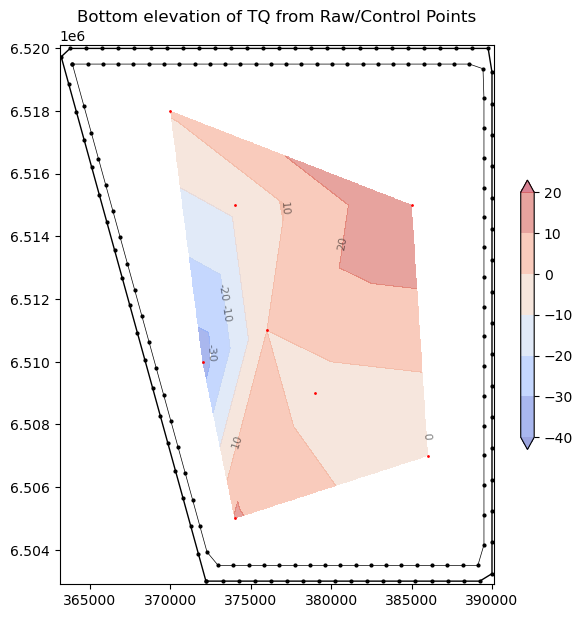

In [60]:
structuralmodel.contour_bottom(spatial, contour_interval = 10, unit = 'TQ',) 


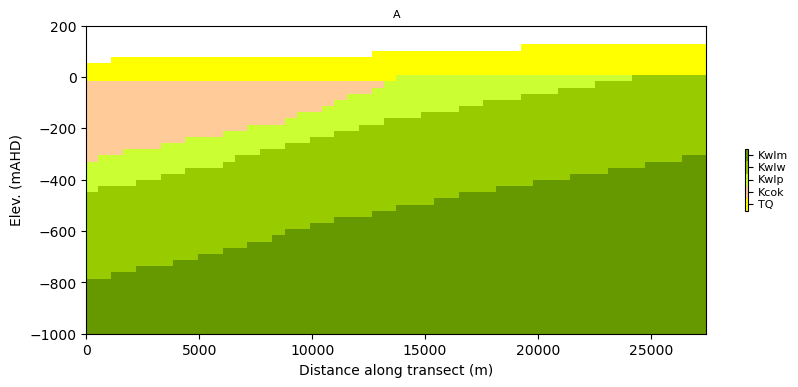

<Figure size 640x480 with 0 Axes>

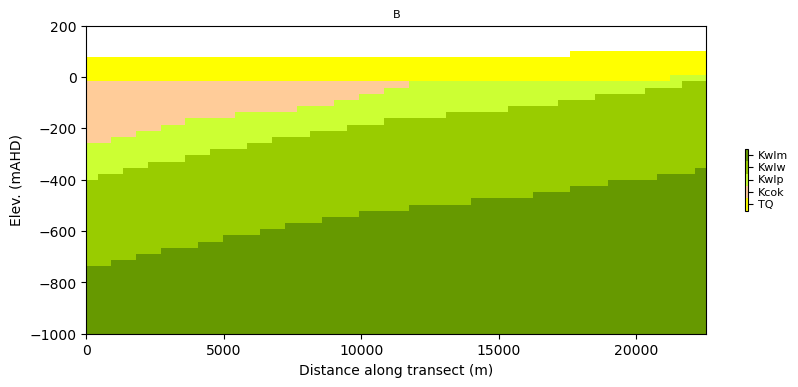

<Figure size 640x480 with 0 Axes>

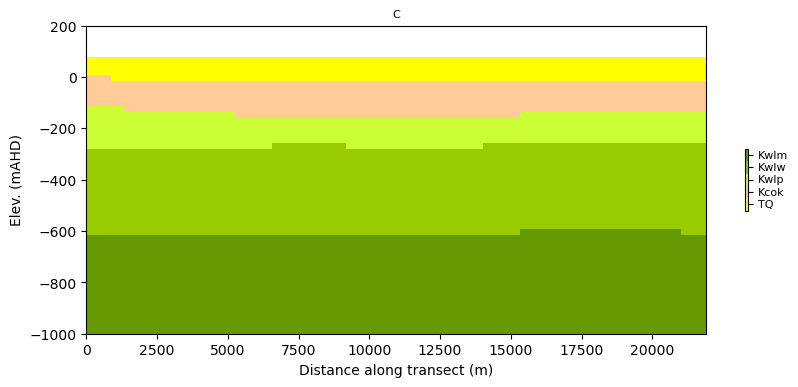

<Figure size 640x480 with 0 Axes>

In [61]:
z0 = -1000 # just for plotting. Make sure within bbox of structural model
z1 = 200   # just for plotting. Make sure within bbox of structural model
nh, nz = 50, 50 # plotting resolution

for i in range(len(spatial.xsections)):
    start = spatial.xsections[i][0]
    end   = spatial.xsections[i][1]

    structuralmodel.plot_xytransect(title = spatial.xsection_names[i], start = start, end = end, z0 = z0, z1 = z1, nh = nh, nz = nz)

['Ground', 'TQ', 'Kcok', 'Leed']


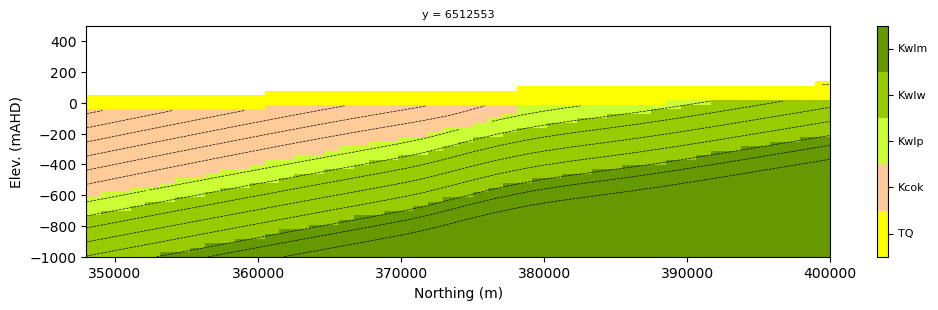

In [62]:
transect_y = [6512553] 
structuralmodel.plot_ytransects2(transect_y, nx = 50, nz = 50, dz = 100)#, faults = False,
#structuralmodel.plot_ytransects(transect_y, nx = 50, nz = 50)#, z0 = -1200, z1 = 200) 
#structuralmodel.data

In [64]:
'''def evaluate_model(structuralmodel, start, end, z0, z1, nh, nz, **kwargs):

    x0 = start[0]
    y0 = start[1]
    x1 = end[0]
    y1 = end[1]

    x = np.linspace(x0, x1, nh)
    y = np.linspace(y0, y1, nh)        
    z = np.linspace(z0, z1, nz)

    X = np.tile(x, (len(z), 1)) 
    Y = np.tile(y, (len(z), 1)) 
    Z = np.tile(z[:, np.newaxis], (1, nh))  # Repeat z along columns (nh times)

    labels = structuralmodel.strat_names[1:]
    ticks = [i for i in np.arange(0,len(labels))]
    boundaries = np.arange(-1,len(labels),1)+0.5

    a = np.array([X.flatten(),Y.flatten(),Z.flatten()]).T
    V = structuralmodel.model.evaluate_model(a).reshape(np.shape(X))

    return V

i = 0 # first transect
start = spatial.xsections[i][0]
end   = spatial.xsections[i][1]
nh, nz = 50, 50
V = evaluate_model(structuralmodel, start, end, z0, z1, nh, nz)
np.unique(V.flatten(), return_counts=True)'''

'def evaluate_model(structuralmodel, start, end, z0, z1, nh, nz, **kwargs):\n\n    x0 = start[0]\n    y0 = start[1]\n    x1 = end[0]\n    y1 = end[1]\n\n    x = np.linspace(x0, x1, nh)\n    y = np.linspace(y0, y1, nh)        \n    z = np.linspace(z0, z1, nz)\n\n    X = np.tile(x, (len(z), 1)) \n    Y = np.tile(y, (len(z), 1)) \n    Z = np.tile(z[:, np.newaxis], (1, nh))  # Repeat z along columns (nh times)\n\n    labels = structuralmodel.strat_names[1:]\n    ticks = [i for i in np.arange(0,len(labels))]\n    boundaries = np.arange(-1,len(labels),1)+0.5\n\n    a = np.array([X.flatten(),Y.flatten(),Z.flatten()]).T\n    V = structuralmodel.model.evaluate_model(a).reshape(np.shape(X))\n\n    return V\n\ni = 0 # first transect\nstart = spatial.xsections[i][0]\nend   = spatial.xsections[i][1]\nnh, nz = 50, 50\nV = evaluate_model(structuralmodel, start, end, z0, z1, nh, nz)\nnp.unique(V.flatten(), return_counts=True)'

### 4. Meshing

In [65]:
# Create mesh object
from loopflopy.mesh import Mesh
special_cells = {
                 'chd': ['east', 'west'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'],
                 'poly': ['lake'], 
                 }
mesh = Mesh(plangrid = 'tri', special_cells = special_cells) # special cells to identify as arguements 

In [68]:
# Define mesh parameters and create mesh
mesh.modelmaxtri = 500000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 400 # 50, 200 radius of inner circle around pumping bores
mesh.radius2 = 800 # 200, 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['bore_refinement_nodes','lake_nodes']#fault_nodes', 'bore_refinement_nodes',]
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

bore_refinement_nodes
lake_nodes
number of cells in plan =  1614


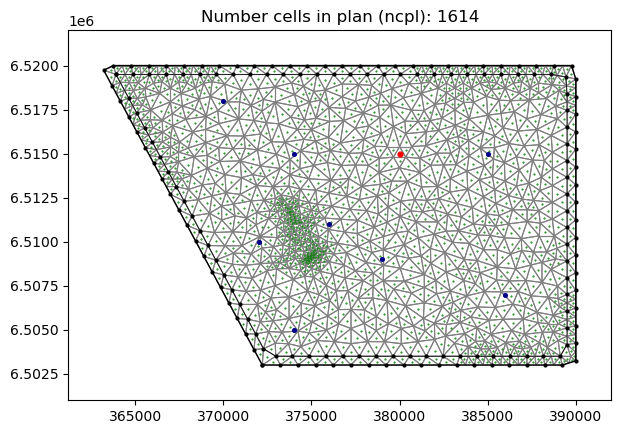

In [69]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

features = ['wel', 'obs', 'lake']
mesh.plot_cell2d(spatial, features, xlim = xlim, ylim = ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['east', 'west']
flag = 1
chd_east_cells [256 265 569 258 261 533 260 530 263 701 290 699 1112 1116 289 269 270 278
 276 281 273 283 274 282 284 287 394 354 345 357 346 365 352 358 349 363
 350 726 730 360 367 714 378 715 380 381 717]
chd_west_cells [15 13 17 14 2 0 3 5 4 7 34 32 35 43 24 22 25 27 26 29 165 144 108 114 111
 1087 1083 678 113 680 112 100 487 98 486 101 490 104 489 491 102 493 105
 122 497 142 499 496 199 495 120 123 125 124]
Group =  wel ['pumpbores']
flag = 3
Group =  obs ['obsbores']
flag = 4
Group =  poly ['lake']
flag = 5
poly_lake_cells
[0 1 2 3 4 5]
[0 1 2 3 4 5]


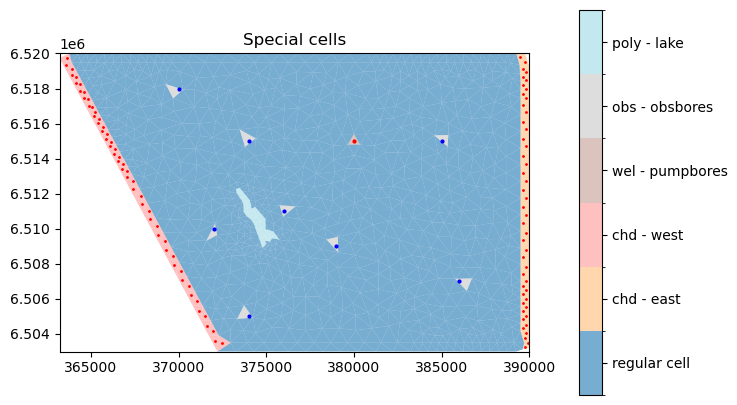

In [70]:
# Locate special cells and plot
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None)

### 5. Topography

In [71]:
from loopflopy.dem import DEM

# Crops large DEM to structural model bounding box
uncropped_dem = DEM(geotiff_fname = "../data/dem/Hydro_Enforced_1_Second_DEM.tif")
uncropped_dem.crop_raster("../data/shp/bbox.shp")
cropped_dem = DEM(geotiff_fname = '../data/dem/cropped_raster.tif')
#cropped_dem.plot_geotiff()

EPSG:28350
EPSG:28350


### 6. Geomodel

In [72]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -1000, 200 

from loopflopy.geomodel import Geomodel # geomodel - pillar method + flat model bottom, geomodel2 - surface method and option to model x number of geolayers
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 3, res = 3) # surfaces calculated at a 3m resolution

EPSG:28350
EPSG:28350
None
EPSG:28350


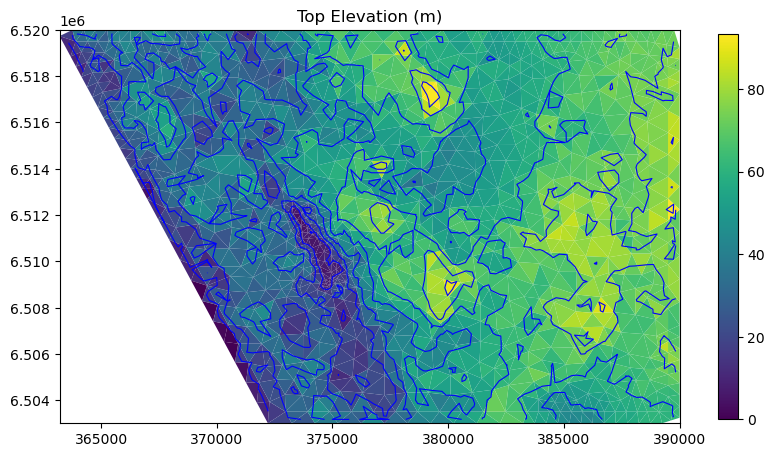

In [73]:
# Crops structuralmodel DEM to geomodel bounding box
geomodel_dem = DEM(geotiff_fname = '../data/dem/cropped_raster.tif')
geomodel_dem.crop_raster(bbox_path =  "../data/shp/model_boundary.shp")
#geomodel_dem.plot_geotiff()

#resample DEM to mesh
geomodel_dem.resample_topo(mesh, fname = '../modelfiles/geomodel_topo.pkl', method="nearest", extrapolate_edges= True,) # only need to run when mesh changes. Take 1-2 minutes
geomodel_dem.load_topo(fname = '../modelfiles/geomodel_topo.pkl')
geomodel_dem.plot_topo(mesh, levels = np.linspace(0, 110, 10))

In [74]:
# Create geomodel surfaces
geomodel.evaluate_structuralmodel(mesh, structuralmodel)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  1.649157
   1. Evaluating structural model...
len(xyz) =  645600
Time taken Block 1 (Evaluate model) =  11.318423


In [75]:
geomodel.create_model_layers(mesh, structuralmodel, geomodel_dem)

   2. Creating geo model layers...
stop_array shape (6, 1614)
nlay =  400
ncpl =  1614
nlg number of geo layers =  5
Time taken Block 2 create geomodel layers  0.08903
   3. Evaluating geo layer thicknesses...
Time taken Block 3 tiny bit 0.000999
   4. Creating flow model layers...
Time taken Block 4 create flow model layers =  0.005002
   5. Calculating gradients...
Time taken Block 5 gradients=  0.777453


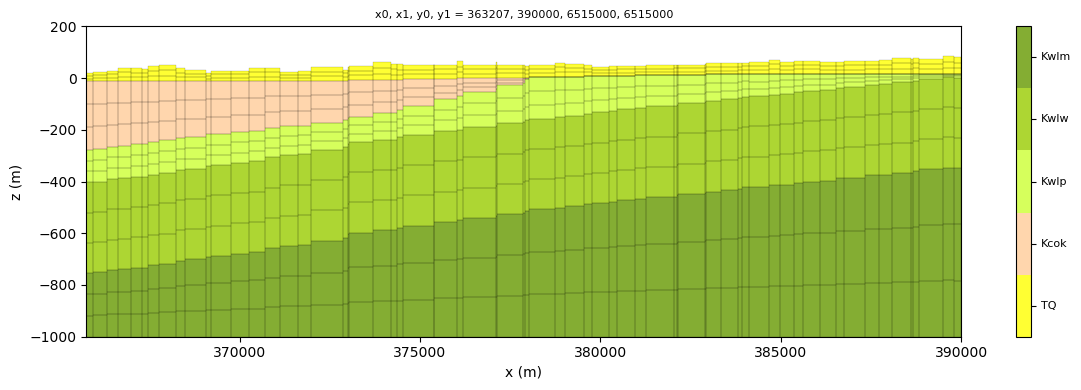

In [76]:
y0, y1 = 6515000, 6515000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1)# z0 = -200, z1 = 300

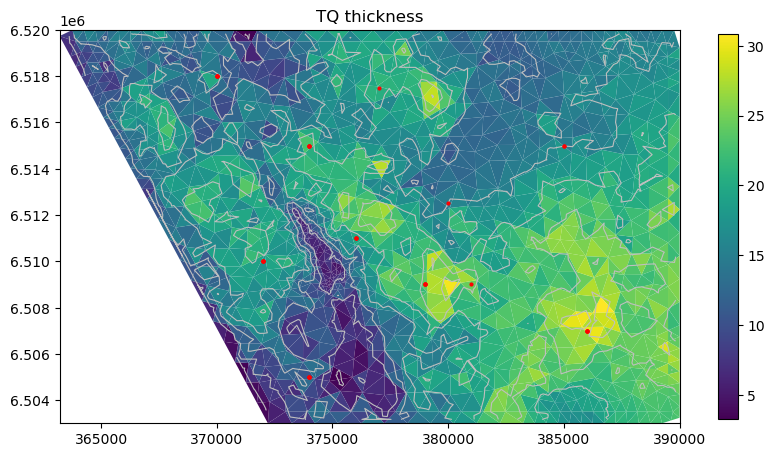

In [84]:
array = geomodel.thick[0] # Top geo layer
title = 'TQ thickness'
mesh.plot_surface_array(array, structuralmodel, title = title, plot_data = True, lithcode = 'TQ')

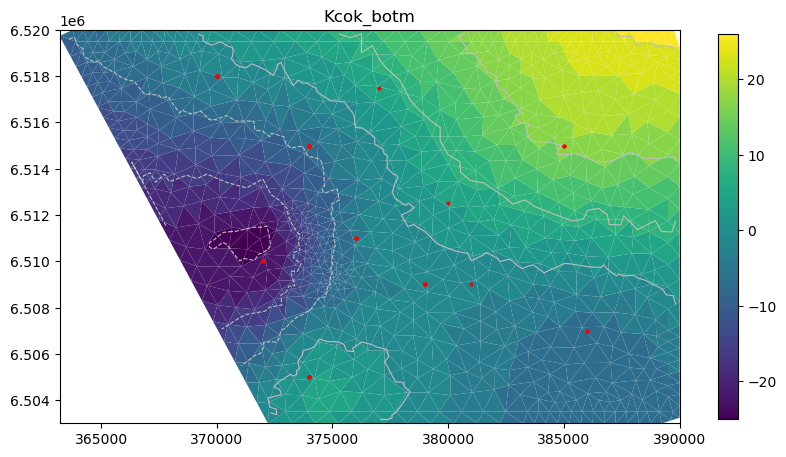

In [85]:
array = geomodel.botm_geo[0] # Top geo layer
title = 'Kcok_botm'
mesh.plot_surface_array(array, structuralmodel, title = title, plot_data = True)#, lithcode = 'Kcok')

### 6. Create synthetic heterogenous field

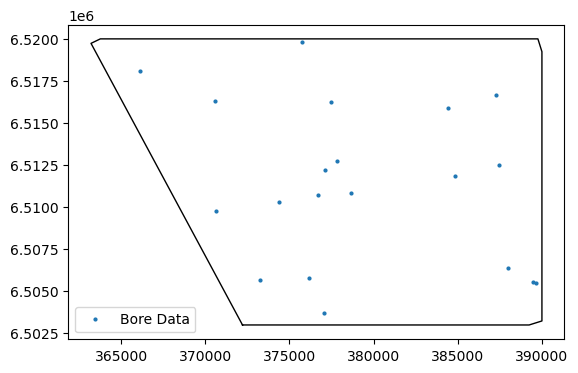

In [86]:
# Create 20 random points
def random_points_in_polygon(polygon, num_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

points = random_points_in_polygon(spatial.model_boundary_poly, 20)
x = [pt.x for pt in points]
y = [pt.y for pt in points]

df = pd.DataFrame({
                'ID': range(len(x)),
                'Easting': x, 
                'Northing': y,                
                })

df.to_excel('../data/random_points.xlsx', index=False)

df = pd.read_excel('../data/random_points.xlsx')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Easting, df.Northing), crs=spatial.epsg)

fig, ax = plt.subplots() 
ax.plot(gdf.geometry.x, gdf.geometry.y, 'o', ms = 2, label = 'Bore Data')  # You can set color, linestyle, etc.
x, y = spatial.model_boundary_poly.exterior.xy
ax.plot(x, y, '-', ms = 2, lw = 1, color='black')
ax.set_aspect('equal')
ax.legend()
plt.show()

In [87]:
# Evaluate scalar field
SF = []
for k, feat in enumerate(structuralmodel.sequence_names[1:]):
    values = structuralmodel.strat[structuralmodel.strat['sequence'] == feat].val.tolist()
    values = sorted(values)
    print(feat, values)
    V = structuralmodel.model.evaluate_feature_value(feat, np.array(geomodel.xyz))
    SF.append(V)


TQ [5]
Kcok [-174]
Leed [-739, -569, -184]


In [88]:
from loopflopy.properties2 import * #Properties

# Create a Properties object to make a truth model
# Then when we calibrate, can create Property "objects" to compare

truth = Properties()
df = pd.read_excel('../data/random_points.xlsx')
df

ID        Easting      Northing
0    0  387259.679201  6.516656e+06
1    1  370638.085408  6.509799e+06
2    2  384806.478344  6.511829e+06
3    3  366131.169201  6.518078e+06
4    4  376714.733395  6.510733e+06
5    5  377487.811112  6.516235e+06
6    6  377801.613926  6.512730e+06
7    7  370569.155075  6.516326e+06
8    8  378644.976154  6.510868e+06
9    9  387996.489748  6.506379e+06
10  10  389630.787430  6.505467e+06
11  11  373234.859939  6.505700e+06
12  12  375752.491668  6.519829e+06
13  13  387443.818003  6.512501e+06
14  14  377110.483429  6.512210e+06
15  15  374396.726779  6.510288e+06
16  16  376178.531239  6.505775e+06
17  17  377022.467755  6.503729e+06
18  18  389466.615593  6.505546e+06
19  19  384446.024145  6.515921e+06

In [93]:
# START WITH TOP UNIT (need to go unit by unit - can loop later)
unit = 'TQ'
scalarfield = SF[0].reshape((geomodel.nlay, geomodel.ncpl))  
gdf = truth.make_stochastic_gdf(geomodel, mesh, spatial, scalarfield, df, unit)
gdf

ID        Easting      Northing                        geometry  \
0    0  387259.679201  6.516656e+06  POINT (387259.679 6516655.979)   
1    1  370638.085408  6.509799e+06  POINT (370638.085 6509799.428)   
2    2  384806.478344  6.511829e+06  POINT (384806.478 6511829.371)   
3    3  366131.169201  6.518078e+06  POINT (366131.169 6518078.035)   
4    4  376714.733395  6.510733e+06  POINT (376714.733 6510733.274)   
5    5  377487.811112  6.516235e+06  POINT (377487.811 6516235.165)   
6    6  377801.613926  6.512730e+06  POINT (377801.614 6512729.799)   
7    7  370569.155075  6.516326e+06  POINT (370569.155 6516325.736)   
8    8  378644.976154  6.510868e+06  POINT (378644.976 6510868.395)   
9    9  387996.489748  6.506379e+06   POINT (387996.49 6506379.357)   
10  10  389630.787430  6.505467e+06  POINT (389630.787 6505467.186)   
11  11  373234.859939  6.505700e+06   POINT (373234.86 6505700.287)   
12  12  375752.491668  6.519829e+06  POINT (375752.492 6519828.705)   
13  13  387443.818003  6.512501e+06  POINT (387443.818 6512500.909)   
14  14  377110.483429  6.512210e+06    POINT (377110.483 6512209.9)   
15  15  374396.726779  6.510288e+06  POINT (374396.727 6510288.497)   
16  16  376178.531239  6.505775e+06  POINT (376178.531 6505775.052)   
17  17  377022.467755  6.503729e+06  POINT (377022.468 6503729.459)   
18  18  389466.615593  6.505546e+06  POINT (389466.616 6505545.748)   
19  19  384446.024145  6.515921e+06  POINT (384446.024 6515920.914)   

    prop_mean  prop_var  icpl                                   cell_xy unit  \
0         0.0       1.0  1023    (387248.2801111894, 6516542.443906702)   TQ   
1         0.0       1.0  1109    (370554.5445929915, 6510034.199103327)   TQ   
2         0.0       1.0  1359   (384611.31240258284, 6512024.605355753)   TQ   
3         0.0       1.0   650    (365953.1382940691, 6518039.345841656)   TQ   
4         0.0       1.0  1612    (376494.8444513868, 6510844.505513235)   TQ   
5         0.0       1.0  1013   (377361.63005012256, 6515953.647581963)   TQ   
6         0.0       1.0   832    (378103.4064344916, 6512713.744057812)   TQ   
7         0.0       1.0  1149    (370752.8799379555, 6516327.271894422)   TQ   
8         0.0       1.0  1202   (378887.45011898974, 6511171.870828732)   TQ   
9         0.0       1.0  1123    (387900.28653309774, 6506595.18305601)   TQ   
10        0.0       1.0   263    (389666.6666666666, 6505311.296328088)   TQ   
11        0.0       1.0   985    (373187.9544477538, 6505763.230961056)   TQ   
12        0.0       1.0   316   (375770.51655705593, 6519666.666666666)   TQ   
13        0.0       1.0  1364    (387300.8028854153, 6512694.549382818)   TQ   
14        0.0       1.0  1198    (377300.9646317871, 6512274.466896738)   TQ   
15        0.0       1.0   218   (374424.94549904583, 6510261.977203792)   TQ   
16        0.0       1.0  1428   (376329.59190669266, 6505754.980677141)   TQ   
17        0.0       1.0   619    (377245.1651682548, 6503739.024321419)   TQ   
18        0.0       1.0   656    (389333.0155127982, 6505347.457611799)   TQ   
19        0.0       1.0  1130  (384427.21369208844, 6515767.7802883675)   TQ   

    geolay  lay  cell_disv  cell_disu     cell_z       sf_z  
0        0    1       2637       2637  43.709251  28.736897  
1        0    1       2723       2723   6.687603  34.564900  
2        0    1       2973       2973  39.306808  36.665237  
3        0    1       2264       2264   9.997689  22.866637  
4        0    1       3226       3226  29.007162  36.031526  
5        0    1       2627       2627  28.352726  29.929066  
6        0    1       2446       2446  26.991695  31.089403  
7        0    1       2763       2763  11.562685  23.156016  
8        0    1       2816       2816  30.094299  34.560283  
9        0    1       2737       2737  29.489288  40.571378  
10       0    1       1877       1877  31.967159  42.011127  
11       0    1       2599       2599  20.312565  27.146286  
12       0    1       193

In [94]:
geomodel.units

array(['TQ', 'Kcok', 'Kwlp', 'Kwlw', 'Kwlm'], dtype='<U4')

In [96]:
# Takes 2.5 minutes to run

anisotropy = (1., 0.5, 100)
CL = 10000.
nugget = 0.05
rebuild_threshold = 0.1
truth.stochasticfieldgeneration(
                unit = 'TQ',
                gdf = gdf,
                geomodel = geomodel, 
                mesh = mesh, 
                property = 'prop', # use generic property to get field between 0 and 1 to later convert to K or other property
                anisotropy = anisotropy, 
                return_random=True, # True makes it random with 0 mean and 1 variance, False makes it deterministic
                CL = CL, 
                nugget = nugget, 
                rebuild_threshold = rebuild_threshold)

######  TQ #########

15 1832
15 TQ disv_cell 1832 val 0.0
10 1877
10 TQ disv_cell 1877 val 0.0
12 1930
12 TQ disv_cell 1930 val 0.0
17 2233
17 TQ disv_cell 2233 val 0.0
3 2264
3 TQ disv_cell 2264 val 0.0
18 2270
18 TQ disv_cell 2270 val 0.0
6 2446
6 TQ disv_cell 2446 val 0.0
11 2599
11 TQ disv_cell 2599 val 0.0
5 2627
5 TQ disv_cell 2627 val 0.0
0 2637
0 TQ disv_cell 2637 val 0.0
1 2723
1 TQ disv_cell 2723 val 0.0
9 2737
9 TQ disv_cell 2737 val 0.0
19 2744
19 TQ disv_cell 2744 val 0.0
7 2763
7 TQ disv_cell 2763 val 0.0
14 2812
14 TQ disv_cell 2812 val 0.0
8 2816
8 TQ disv_cell 2816 val 0.0
2 2973
2 TQ disv_cell 2973 val 0.0
13 2978
13 TQ disv_cell 2978 val 0.0
16 3042
16 TQ disv_cell 3042 val 0.0
4 3226
4 TQ disv_cell 3226 val 0.0
points_values_3d.shape  (4842, 4)


AttributeError: 'Properties' object has no attribute 'sills'

In [ ]:
prop_df = pd.read_excel('../data/example_data.xlsx', sheet_name = 'prop_bounds')
prop_df


sequence  unit  iconvert  min_kh  max_kh  min_kv  max_kv  min_sy  max_sy  \
0       TQ    TQ         1    1.00     100   0.100    10.0    0.05     0.2   
1     Kcok  Kcok         0    0.05       5   0.005     0.5    0.05     0.2   
2     Leed  Kwlp         0    0.10      10   0.010     1.0    0.05     0.2   
3     Leed  Kwlw         0    1.00     100   0.100    10.0    0.05     0.2   
4     Leed  Kwlm         0    0.10      10   0.010     1.0    0.05     0.2   

    min_ss  max_ss  
0  0.00001  0.0001  
1  0.00001  0.0001  
2  0.00001  0.0001  
3  0.00001  0.0001  
4  0.00001  0.0001

In [ ]:
#plt.plot(geomodel.zc[0], 'o')
#plt.plot(geomodel.zc[1], 'o')
#plt.plot(geomodel.zc[2], 'o')
#plt.plot(geomodel.zc[3], 'o')
#plt.show()  # Ensure the plot is displayed

np.random.uniform(0, 1, 20)

array([0.65681391, 0.18685341, 0.97298195, 0.12968027, 0.76296112,
       0.27813618, 0.55743167, 0.27733816, 0.95288312, 0.93169161,
       0.58348858, 0.46075009, 0.6152998 , 0.84444375, 0.97216896,
       0.22757911, 0.14951974, 0.63164923, 0.9321645 , 0.94319351])

### OLD WAY

In [ ]:
def pick_prop_value(unit, prop, prop_df, npoints):

    logmin = np.log10(prop_df.loc[prop_df['unit'] == unit, f"min_{prop}"].values[0])
    logmax = np.log10(prop_df.loc[prop_df['unit'] == unit, f"max_{prop}"].values[0])
    print(f'log10 kh range for {unit} = {logmin:.2f} to {logmax:.2f}')
    prop = 10**(logmin + np.random.uniform(0, 1, npoints) * (logmax - logmin))
    return prop

def make_truth_df(unit, npoints, spatial, prop_df):

    points = random_points_in_polygon(spatial.model_boundary_poly, npoints)
    x = [pt.x for pt in points]
    y = [pt.y for pt in points]

    df = pd.DataFrame({
                    'ID': [f'{unit}_{i+1}' for i in range(npoints)],
                    'Easting': x, 
                    'Northing': y, 
                    'Unit': unit,                
                    'kh': pick_prop_value(unit, 'kh', prop_df, npoints),
                    'kv': pick_prop_value(unit, 'kv', prop_df, npoints),
                    'ss': pick_prop_value(unit, 'ss', prop_df, npoints),
                    'sy': pick_prop_value(unit, 'sy', prop_df, npoints),                  
                    })
    return df

unit, npoints = 'TQ', 20
df = make_truth_df(unit, npoints, spatial, prop_df)

unit, npoints = 'Kcok', 20
df_new = make_truth_df(unit, npoints, spatial, prop_df)
df = pd.concat([df, df_new], ignore_index=True)

unit, npoints = 'Kwlp', 20
df_new = make_truth_df(unit, npoints, spatial, prop_df)
df = pd.concat([df, df_new], ignore_index=True)

unit, npoints = 'Kwlw', 20
df_new = make_truth_df(unit, npoints, spatial, prop_df)
df = pd.concat([df, df_new], ignore_index=True)

unit, npoints = 'Kwlm', 20
df_new = make_truth_df(unit, npoints, spatial, prop_df)
df = pd.concat([df, df_new], ignore_index=True)

df.to_excel('../data/truth_properties.xlsx', index=False)

log10 kh range for TQ = 0.00 to 2.00
log10 kh range for TQ = -1.00 to 1.00
log10 kh range for TQ = -5.00 to -4.00
log10 kh range for TQ = -1.30 to -0.70
log10 kh range for Kcok = -1.30 to 0.70
log10 kh range for Kcok = -2.30 to -0.30
log10 kh range for Kcok = -5.00 to -4.00
log10 kh range for Kcok = -1.30 to -0.70
log10 kh range for Kwlp = -1.00 to 1.00
log10 kh range for Kwlp = -2.00 to 0.00
log10 kh range for Kwlp = -5.00 to -4.00
log10 kh range for Kwlp = -1.30 to -0.70
log10 kh range for Kwlw = 0.00 to 2.00
log10 kh range for Kwlw = -1.00 to 1.00
log10 kh range for Kwlw = -5.00 to -4.00
log10 kh range for Kwlw = -1.30 to -0.70
log10 kh range for Kwlm = -1.00 to 1.00
log10 kh range for Kwlm = -2.00 to 0.00
log10 kh range for Kwlm = -5.00 to -4.00
log10 kh range for Kwlm = -1.30 to -0.70


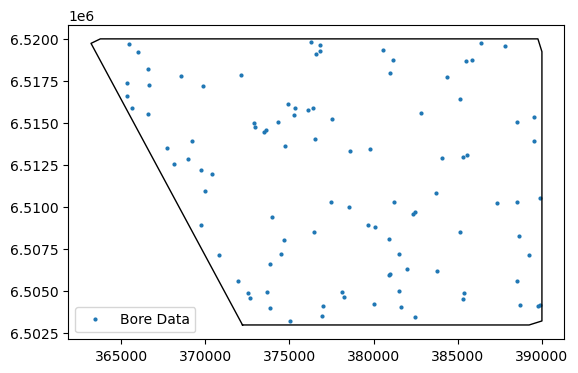

In [ ]:
# LoopFlopy object
from loopflopy.properties import * #Properties
truth = Properties()
df = pd.read_excel('../data/truth_properties.xlsx')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Easting, df.Northing), crs=spatial.epsg)


fig, ax = plt.subplots() 
ax.plot(gdf.geometry.x, gdf.geometry.y, 'o', ms = 2, label = 'Bore Data')  # You can set color, linestyle, etc.
x, y = spatial.model_boundary_poly.exterior.xy
ax.plot(x, y, '-', ms = 2, lw = 1, color='black')
ax.set_aspect('equal')
ax.legend()
plt.show()

In [ ]:
truth.make_gdf(geomodel, mesh, spatial, df)
truth.gdf

ID        Easting      Northing  Unit         kh        kv        ss  \
0      TQ_1  382331.200656  6.509590e+06    TQ   7.025100  7.042787  0.000035   
1      TQ_2  375248.304222  6.515469e+06    TQ  19.689907  0.452839  0.000045   
2      TQ_3  381618.855742  6.504047e+06    TQ   6.338356  0.252485  0.000028   
3      TQ_4  376905.416215  6.503543e+06    TQ  59.735976  0.766544  0.000016   
4      TQ_5  367693.776984  6.513507e+06    TQ   3.167157  0.230606  0.000027   
..      ...            ...           ...   ...        ...       ...       ...   
95  Kwlm_16  369766.572153  6.512219e+06  Kwlm   0.331197  0.103210  0.000012   
96  Kwlm_17  388543.737825  6.505627e+06  Kwlm   4.854271  0.064932  0.000096   
97  Kwlm_18  385381.173105  6.504894e+06  Kwlm   1.131280  0.118862  0.000093   
98  Kwlm_19  373850.047656  6.506608e+06  Kwlm   0.443930  0.045391  0.000012   
99  Kwlm_20  381486.080218  6.504992e+06  Kwlm   7.775302  0.035302  0.000034   

          sy                        geometry    log_kh    log_kv    log_ss  \
0   0.066686  POINT (382331.201 6509590.316)  0.846653  0.847745 -4.453050   
1   0.178946  POINT (375248.304 6515468.861)  1.294244 -0.344056 -4.349297   
2   0.054596  POINT (381618.856 6504046.603)  0.801977 -0.597764 -4.547091   
3   0.187228  POINT (376905.416 6503542.572)  1.776236 -0.115463 -4.799082   
4   0.149929  POINT (367693.777 6513507.247)  0.500670 -0.637129 -4.563571   
..       ...                             ...       ...       ...       ...   
95  0.135653  POINT (369766.572 6512218.663) -0.479913 -0.986279 -4.938844   
96  0.070312  POINT (388543.738 6505626.871)  0.686124 -1.187540 -4.015976   
97  0.164872  POINT (385381.173 6504894.324)  0.053570 -0.924958 -4.032990   
98  0.075354  POINT (373850.048 6506608.135) -0.352686 -1.343032 -4.924206   
99  0.193609   POINT (381486.08 6504991.555)  0.890717 -1.452195 -4.465447   

    icpl                                  cell_xy  geolay  lay  cell_disv  \
0   1482   (382093.3481164545, 6509813.744988617)       0    1       3096   
1   1010  (375001.63294660515, 6515293.734953406)       0    1       2624   
2   1042  (381520.18307150307, 6504097.319922446)       0    1       2656   
3    619   (377245.1651682548, 6503739.024321419)       0    1       2233   
4    681   (367667.6123455258, 6513226.322237023)       0    1       2295   
..   ...                                      ...     ...  ...        ...   
95  1096  (369797.9770949765, 6512468.8549553435)       4   13      22078   
96   753    (388325.0456104391, 6505723.91094782)       4   13      21735   
97  1074   (385807.8934233579, 6505104.308520835)       4   13      22056   
98  1388   (373960.7769451695, 6506338.363534517)       4   13      22370   
99  1343   (381593.7289333038, 6505322.228494655)       4   13      22325   

    cell_disu  cell_z      sill  
0        3096    50.0  1.061684  
1        2624    45.5  1.061684  
2        2656    44.0  1.061684  
3        2233    50.0  1.061684  
4        2295    30.5  1.061684  
..        ...     ...       ...  
95      20182  -854.5  0.081415  
96      19839  -724.0  0.081415  
97      20160  -743.5  0.081415  
98      20474  -824.5  0.081415  
99      20429  -764.5  0.081415  

[94 rows x 20 columns]

In [ ]:
# Takes 2.5 minutes to run

anisotropy = (1., 0.5, 0.001)
CL = 10000.
nugget = 0.05
rebuild_threshold = 0.1

property = 'kh'
#truth.kriging(geomodel, mesh, anisotropy, CL, nugget, rebuild_threshold, return_random=False)
truth.stochasticfieldgeneration(
                geomodel, 
                mesh, 
                property = property,
                anisotropy = (1., 1., 1.), 
                return_random=True, # True makes it random with 0 mean and 1 variance, False makes it deterministic
                CL = 1000., 
                nugget = 0.05, 
                rebuild_threshold = 0.1)

######  TQ #########

TQ_7 TQ disv_cell 1960 val 0.016666847692651535
TQ_6 TQ disv_cell 1996 val 0.3217022052440768
TQ_14 TQ disv_cell 2123 val 0.801099427260455
TQ_4 TQ disv_cell 2233 val 1.7762359628757816
TQ_19 TQ disv_cell 2248 val 1.7691534502902226
TQ_16 TQ disv_cell 2274 val 1.0919736066632195
TQ_5 TQ disv_cell 2295 val 0.5006695961181737
TQ_20 TQ disv_cell 2353 val 0.5236607592125644
TQ_11 TQ disv_cell 2508 val 1.3401732065745933
TQ_8 TQ disv_cell 2577 val 1.8309194325409486
TQ_2 TQ disv_cell 2624 val 1.2942436605836336
TQ_3 TQ disv_cell 2656 val 0.8019766130811412
TQ_12 TQ disv_cell 2703 val 1.670879520179949
TQ_13 TQ disv_cell 2752 val 1.51922343949276
TQ_10 TQ disv_cell 2873 val 1.892500574268111
TQ_1 TQ disv_cell 3096 val 0.8466525052236242
TQ_17 TQ disv_cell 3120 val 1.4259421565510044
TQ_18 TQ disv_cell 3153 val 0.5066548451676482
TQ_15 TQ disv_cell 3221 val 1.2172670923185749
TQ_9 TQ disv_cell 3222 val 0.08608525358164838
points_values_3d.shape  (4842, 4)
sill  1.0616840

TypeError: optimized_kriging() got an unexpected keyword argument 'initial_points'

In [ ]:
# Takes 2.5 minutes to run

anisotropy = (1., 0.5, 100)
CL = 10000.
nugget = 0.05
rebuild_threshold = 0.1
property = 'prop' # use generic property to get field between 0 and 1
#truth.kriging(geomodel, mesh, anisotropy, CL, nugget, rebuild_threshold, return_random=False)
truth.stochasticfieldgeneration(
                geomodel, 
                mesh, 
                property = property,
                anisotropy = anisotropy, 
                return_random=True, # True makes it random with 0 mean and 1 variance, False makes it deterministic
                CL = CL, 
                nugget = nugget, 
                rebuild_threshold = rebuild_threshold)


######  TQ #########

TQ_10 1966


KeyError: 'prop'

In [ ]:
# Takes 6.5 - 7 minutes to run
property = 'kv'
truth.kriging(geomodel, mesh, property, anisotropy, CL, nugget, rebuild_threshold)

property = 'sy'
truth.kriging(geomodel, mesh, property, anisotropy, CL, nugget, rebuild_threshold)

property = 'ss'
truth.kriging(geomodel, mesh, property, anisotropy, CL, nugget, rebuild_threshold)

######  TQ #########

OBS7 TQ disv_cell 4655 val 0.3010299956639812
OBS3 TQ disv_cell 6288 val -0.3010299956639812
OBS4 TQ disv_cell 6452 val 0.47712125471966244
OBS5 TQ disv_cell 6886 val -0.2218487496163564
OBS6 TQ disv_cell 7432 val -1.0
OBS2 TQ disv_cell 8637 val -1.0
OBS1 TQ disv_cell 8996 val 0.3010299956639812
points_values_3d.shape  (13800, 4)
sill  1.0430042850948544
7
prop_values  (13800,)
prop_values  (3, 4600)
######  Kcok #########

OBS7 Kcok disv_cell 18455 val -2.0
OBS3 Kcok disv_cell 20088 val -2.3979400086720375
OBS4 Kcok disv_cell 20252 val -1.3010299956639813
OBS6 Kcok disv_cell 21232 val -1.3979400086720375
OBS2 Kcok disv_cell 22437 val -2.5228787452803374
OBS1 Kcok disv_cell 22796 val -2.3010299956639813
points_values_3d.shape  (13800, 4)
sill  0.5892769623726143
6
prop_values  (13800,)
prop_values  (3, 4600)
######  Kwlp #########

OBS7 Kwlp disv_cell 32255 val -0.3010299956639812
OBS3 Kwlp disv_cell 33888 val -0.1549019599857432
OBS4 Kwlp disv_cell 34052 val -1.3

In [ ]:
print(geomodel.ncell_disv)
print(geomodel.ncell_disu)
print(truth.kh_layicpl_ma.shape)
print(truth.kh_disv.shape)
print(truth.kh_disu.shape)

print('Numer of geological layers = ', geomodel.nlg)
print('Number of sublayers per geological layer = ', geomodel.nls)
print('Number of model layers = ', geomodel.nlay)
top_layers = [geomodel.nls * geolay for geolay in range(geomodel.nlg)]
top_layers

69000
65853
(15, 4600)
(69000,)
(65853,)
Numer of geological layers =  5
Number of sublayers per geological layer =  3
Number of model layers =  15


[0, 3, 6, 9, 12]

In [ ]:
print(type(truth.kh_disu))

<class 'numpy.ndarray'>


0 TQ


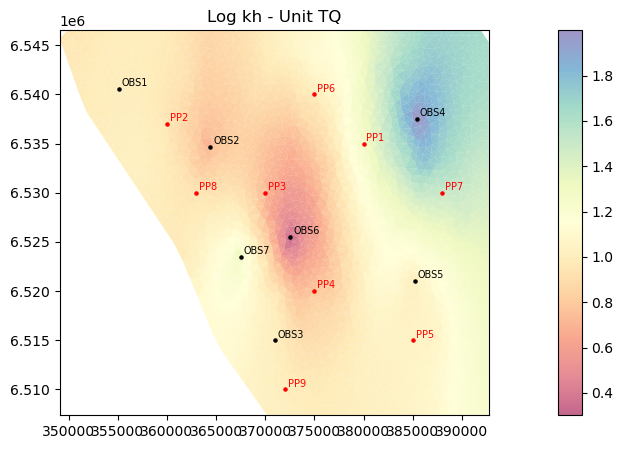

3 Kcok


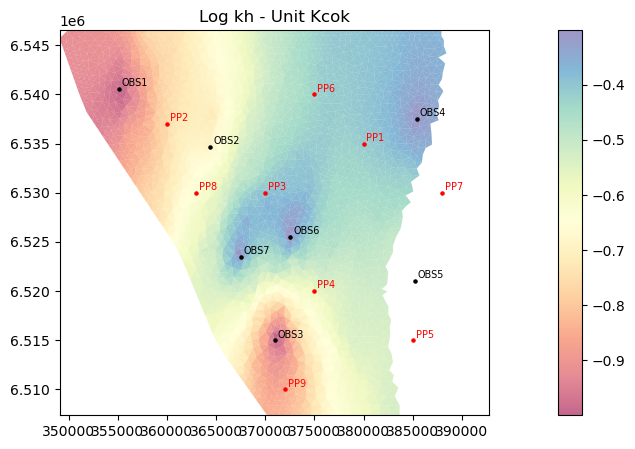

6 Kwlp


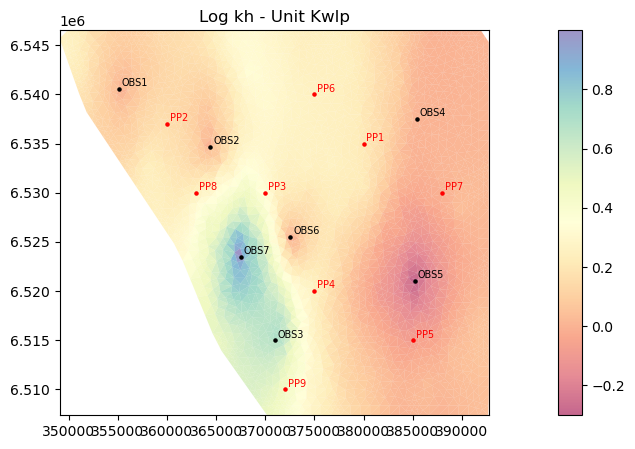

9 Kwlw


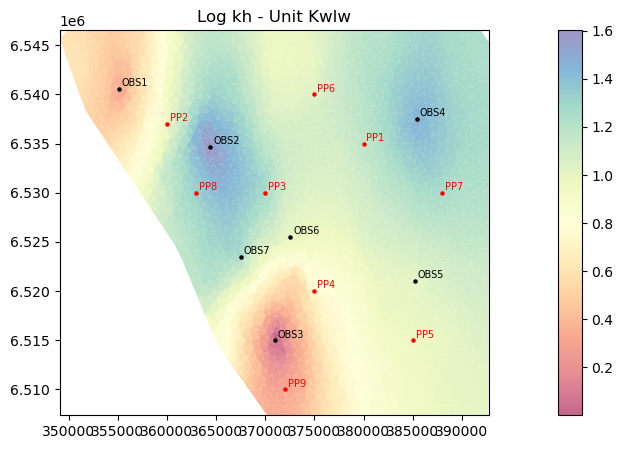

12 Kwlm


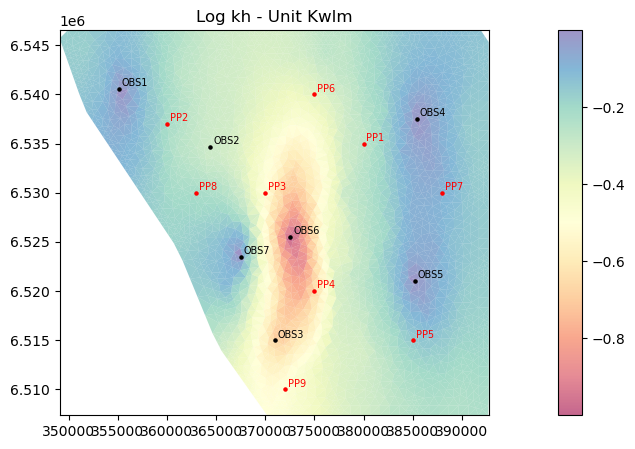

In [ ]:
for i, lay in enumerate(top_layers):  
    unit = geomodel.units[i]
    print(lay, unit)
    truth.plot_propfield(mesh, spatial, lay, unit, property = 'kh') # lay = model layer, unit = geological unit

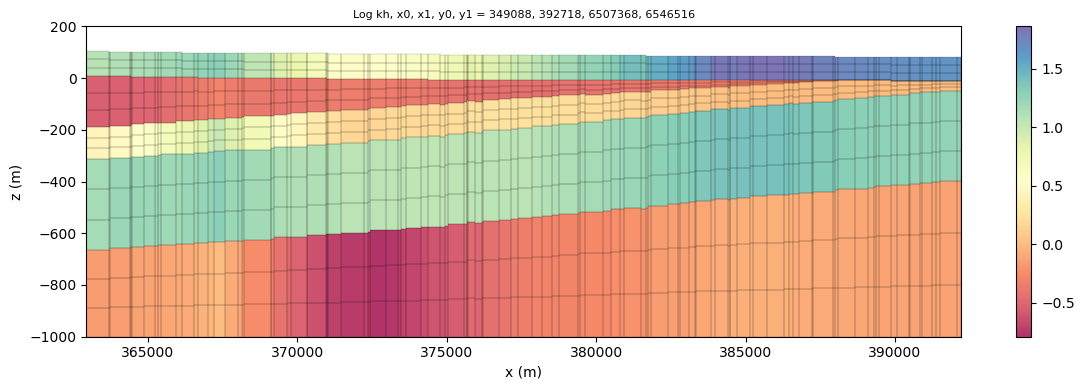

In [ ]:
#spatial.xsections = [[(355000, 6530000),(400000, 6540000)], [(365000, 6510000),(400000, 6525000)]]
x0, x1, y0, y1 = spatial.xsections[0][0][0], spatial.xsections[0][1][0], spatial.xsections[0][0][1], spatial.xsections[0][1][1]
truth.plot_propfield_usg(geomodel, spatial, x0, x1, y0, y1, property = 'kh')

In [ ]:
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'properties')
geomodel.iconvert_perlay = props.iconvert.tolist()

geomodel.fill_cell_properties_heterogeneous(truth)

   6. Filling cell properties...
ang1 shape  (15, 4600)
65853
angle1 shape  (65853,)
Time taken Block 6 Fill cell properties =  0.003043


### 6. Prepare Data for Flowmodel

In [ ]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

wel_q = [-100000, 0]
wel_qlay= [0, 0]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)

Well screens  [(np.float64(-1000.0), np.float64(-1.0)), (np.float64(-1000.0), np.float64(2.0))]


#### Process Observations

In [ ]:
df = pd.read_excel('../data/example_data.xlsx', sheet_name = 'obs_bores')
import process_observations
gdf = process_observations.make_obs_gdf(df, geomodel, mesh, spatial)

from loopflopy.observations import Observations
observations = Observations(gdf)
observations.make_recarray() # makes recarray for flowmodel

print(observations.gdf)

     id         x        y    z   kh                  geometry  cell_disv  \
0  OBS1  355120.0  6540562  -50    5    POINT (355120 6540562)      18196   
1  OBS2  364415.7  6534636 -100    1  POINT (364415.7 6534636)      22437   
2  OBS3  371000.0  6515000 -100   10    POINT (371000 6515000)      24688   
3  OBS4  385447.0  6537497 -500  100    POINT (385447 6537497)      57052   
4  OBS5  385200.0  6521000 -100    1    POINT (385200 6521000)      34486   
5  OBS6  372541.0  6525478 -100    3    POINT (372541 6525478)      25832   
6  OBS7  367502.0  6523500  -50   10    POINT (367502 6523500)      13855   

   cell_disu  (lay,icpl)  lay  icpl                               obscell_xy  \
0      17149   (3, 4396)    3  4396  (355330.98438145826, 6540327.512844525)   
1      20364   (4, 4037)    4  4037  (364261.74735699437, 6534934.394501741)   
2      21895   (5, 1688)    5  1688   (371047.0029852411, 6515430.307171156)   
3      53905  (12, 1852)   12  1852   (385496.5384433281, 65373

### 8. Create and run steady-state flow model

In [ ]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
xt3d =  True
   Time taken to write flow model =  20.016196
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  11.679035
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 65853)


In [ ]:
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
chd
chdflow
data
geomodel
gwf
head
lith
logk11
logk33
mesh
newtonoptions
obs
obsdata
observations
project
rch
runtime
scenario
spd
staggered
wel
xt3d


In [ ]:
# IF A PROBLEM NODE FROM MFSIM, CAN LOT LOCATION HERE!
#utils.plot_node(1508-1, geomodel, structuralmodel, spatial, sim, scenario, z1 = 500, features = ['fault'])

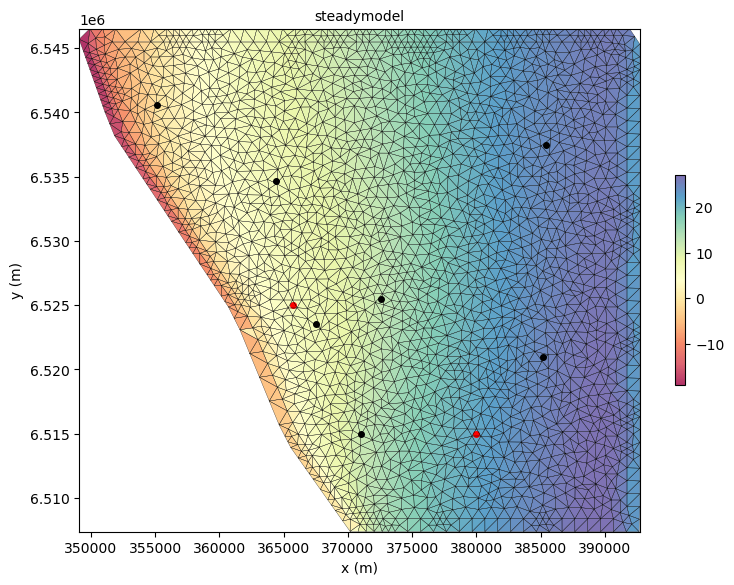

In [ ]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable,)#, extent, vmin, vmax

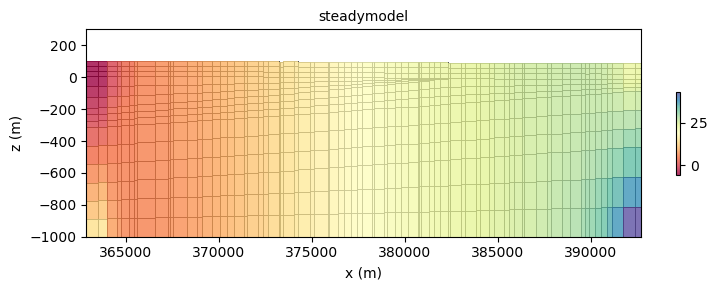

In [ ]:
fm.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)

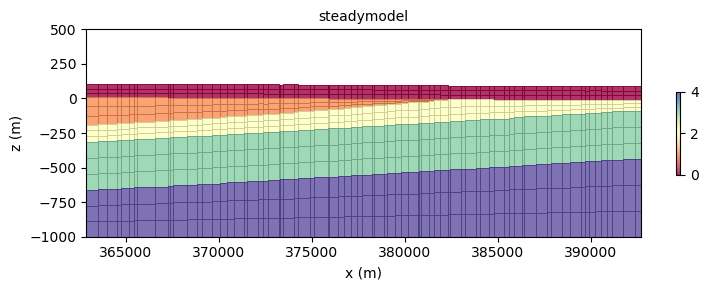

In [ ]:
fm.plot_transect(spatial, structuralmodel, 'lith', y0 = 6520000, y1 = 6520000)

In [ ]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_plan', 'plot_transect', 'plot_watertable', 'run_flowmodel', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'geomodel', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'wel', 'xt3d']


### Create a steady state "truth"

In [ ]:
# Get convert obs package to arrays of oberservation heads
heads_truth = fm.head

# Get times
csv_file = os.path.join('../results/ref_past.csv')
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
csv_file = os.path.join(project.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2
times = list(times_past) + list(times_future)

# Pickle reference results
fname = P.results + 'times.pkl'
pickle.dump(times, open(os.path.join(fname),'wb'))
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(fname),'wb'))


### 9. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
fm2 = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
fm2.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

Well screens  [(np.float64(-1000.0), np.float64(32.0)), (np.float64(-1000.0), np.float64(6.0))]


In [ ]:
sim = fm2.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

   Writing simulation and gwf for  transientmodel  ...
   Time taken to write flow model =  5.524102


In [ ]:
fm2.run_flowmodel(sim, transient = True)

Running simulation for  transientmodel  ...
Model success =  True
   run_time =  10.117995
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 13358)


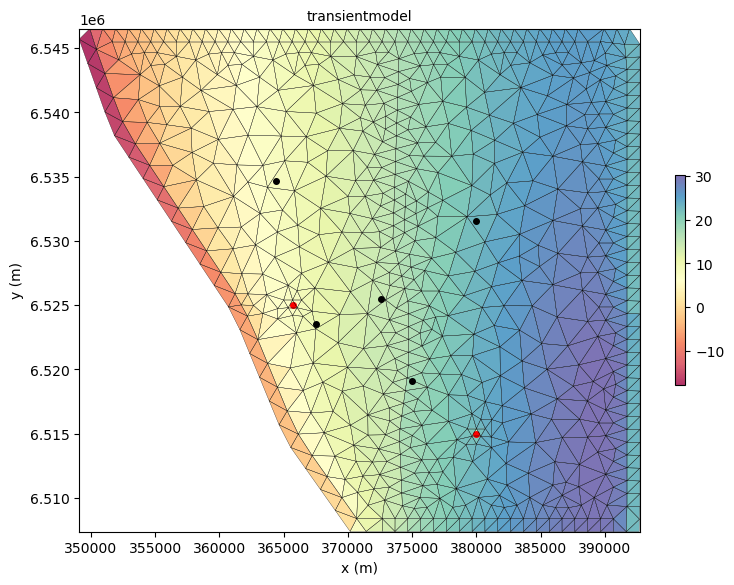

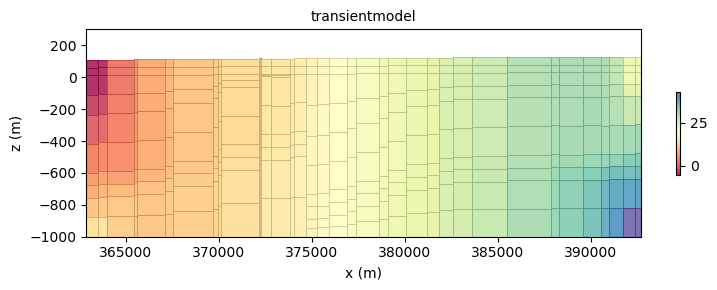

In [ ]:
watertable = fm2.get_watertable(geomodel, fm2.head)
fm2.plot_watertable(spatial, mesh, geomodel, fm2, watertable,)#, extent, vmin, vmax
fm2.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)

#### Create "truth" observations and plot

In [ ]:
# Get convert obs package to arrays of oberservation heads
R.ref_steady  = functions.process_obs_steady(P, R)
R.ref_past    = functions.process_obs_past(P, R)
R.ref_future  = functions.process_obs_future(P, R)

# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2
times = list(times_past) + list(times_future)

# Pickle reference results
fname = P.results + 'ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(fname),'wb'))
fname = P.results + 'times.pkl'
pickle.dump(times, open(os.path.join(fname),'wb'))

In [ ]:
# PLOT REFERENCE OBSERVATIONS
import matplotlib.pyplot as plt
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

In [ ]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.05
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', ms = 1, label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', ms = 1, label = 'perturbed heads')
plt.xlabel('Observation index')
plt.ylabel('Head (m)')
plt.legend()

In [ ]:
%run ./figures.ipynb   
figure8(P, R)

#### Prepare PEST input arrays

In [ ]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - HEADS.INS)
hobs_ref.shape #(5, 3, 12)
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            print('l1 [OBS%i_%i.%i]1:20' %(i, j, k))

In [ ]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - CONTROL.PST)
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            print('OBS%i_%i.%i  %f  10.0  head' %(i, j, k, hobs_ref[i, j, k]))

#### Prepare parameter bounds

In [ ]:
# LOG
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

print(k_min)
print(k_max)
print(k_mean)

In [ ]:
pickleoff = open('../results/reference.pkl','rb')
reference = pickle.load(pickleoff)
pickleoff.close()

# BLUE - MAX/MIN
# ORANGE - MEAN
# RED - ACTUAL
fig = plt.figure(figsize = (12,5))
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2][1:]), 'o', color = 'red')
plt.ylabel('Log')
plt.xticks(np.linspace(0,10,11), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

#### Pilot Point Setup

In [ ]:
properties = Properties() # set up a new properties object
df = pd.read_excel('../data/example_data.xlsx', sheet_name = 'pilot_points')
properties.make_gdf(geomodel, mesh, spatial, df)
#print(properties.gdf)

anisotropy = (1., 1., 0.0001)
CL = 5000.
nugget = 0.05
rebuild_threshold = 0.1

properties.kriging(geomodel, mesh, anisotropy, CL, nugget, rebuild_threshold)

#spatial.xsections = [[(355000, 6530000),(400000, 6540000)], [(365000, 6510000),(400000, 6525000)]]
x0, x1, y0, y1 = spatial.xsections[0][0][0], spatial.xsections[0][1][0], spatial.xsections[0][0][1], spatial.xsections[0][1][1]
properties.plot_propfield_usg(geomodel, spatial, x0, x1, y0, y1, property = 'kh')

'''# LOG
k_min = [0, -2, 0, -2]
k_max = [1, -1, 1, -1]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

print(k_min)
print(k_max)
print(k_mean)

Min.append(k_min[i+8]) 
Max.append(k_max[i+8])

# LAYER K
nr_param = 200 # Create lots of parameter sets
nr = 100 # How many successful flow models we want
import random 
logfunc = lambda e: np.log10(e)

def normal_sampling(mu, sigma, nr_param):
    nums = [] 
    count = 0
    while count < nr_param:
        temp = random.gauss(mu,sigma) 
        if temp >= mu - 3 * sigma and temp <= mu + 3*sigma:
            nums.append(temp)
            count += 1
    return(nums)

hk_mu = np.copy(hk) # from variables.ipynb
hk_mu_log = logfunc(hk_mu)
hk_sigma_log = [0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66]

vk_mu = np.copy(vk) # from variables.ipynb
vk_mu_log = logfunc(vk_mu)
vk_sigma_log = [0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66]

hk_parameters = []
vk_parameters = []

for n in range(8): # for each layer
    hk_parameters.append(normal_sampling(hk_mu_log[n], hk_sigma_log[n], nr_param))'''

#### History Matching

In [ ]:
def plot_scalarfield(self, transect_y, nx, nz, **kwargs):

        self.sequence_names = []
        for item in self.strat['sequence'].tolist():
            if item not in self.sequence_names:
                self.sequence_names.append(item)

        x0 = kwargs.get('x0', self.x0)
        z0 = kwargs.get('z0', self.z0)
        x1 = kwargs.get('x1', self.x1)
        z1 = kwargs.get('z1', self.z1)
        
        z = np.linspace(z0, z1, nz)
        x = np.linspace(x0, x1, nx)
        X,Z = np.meshgrid(x,z)

        labels = self.strat_names[1:]
        ticks = [i for i in np.arange(0,len(labels))]
        boundaries = np.arange(-1,len(labels),1)+0.5
        Y = np.zeros_like(X)
        Y[:,:] = transect_y[0]
        V = self.model.evaluate_model(np.array([X.flatten(),Y.flatten(),Z.flatten()]).T).reshape(np.shape(Y))
        
        for i, n in enumerate(transect_y):
            fig = plt.figure(figsize=(12, 3))
            ax = plt.subplot(len(transect_y), 1, i+1)
            

            val_above = 0
            # Evaluate scalar fields for each feature to plot contours
            for feat in self.sequence_names:
                print(feat)
                A = self.model.evaluate_feature_value(feat, np.array([X.flatten(),Y.flatten(),Z.flatten()]).T).reshape(np.shape(Y))
                print(A.shape)
                ax.imshow(np.ma.masked_where(V<0,A), origin = "lower", extent = [x0,x1,z0,z1])

            # Evaluate faults to plot
            #for fault in self.faults:
            #    F = self.model.evaluate_feature_value(fault, np.array([X.flatten(),Y.flatten(),Z.flatten()]).T).reshape(np.shape(Y))
            #    ax.contour(X, Z, F, levels = [0], colors = 'Black', linewidths=2., linestyles = 'dashed') 
            if i < (len(transect_y)-1):
                ax.set_xticks(ticks = [], labels = [])
            else:
                ax.set_xlabel('Northing (m)')

            #cbar.ax.set_yticks(ticks = ticks, labels = labels, size = 8, verticalalignment = 'center')    
            ax.set_title("y = " + str(transect_y[i]), size = 8)
            ax.set_ylabel('Elev. (mAHD)')
            ax.set_aspect('10') #0.5, 'equal'
            #plt.axis('equal')
            plt.savefig('../figures/structural_ytransects.png')
            plt.show()

plot_scalarfield(structuralmodel, transect_y, nx = 60, nz = 60, z0 = -200, )#z1 = 000) #x0 = 370000, x1 = 374000, 